# Parallelizing a chess engine

## Introduction 

   One of the most classical challenges in artificial intelligence and computer science in general is chess programming. At first glance, it may appear relatively easy and straightforward compared to others problems, but when we think about it, we quickly realize that it is not easy at all given the necessity to enumerate every single possible move imaginable. If that is not enough, there exist 10 to the power of 120 (that is 1 followed by 120 zeros) possibilities. The entire universe contains nearly 10 to the power of 80 atoms! Quite a gap, isn’t it?
   
This outstriking number gave chess programming all the interest in computer science research we witness today. Fortunately for us, there exist an algorithm which gives computers the ability to play chess, that is the Minimax algorithm. The minimax; from a given node in the search tree, computes all its children (that is the set of all the possibles moves from the current configuration) and visits each child one by one, computing each time an evaluation function that gives away a kind of performance of that child. We repeat that recursively until we reach the leaves. At the end, the algorithm chooses the branch with the highest evaluation. However, the search tree being too large, we generally stop at a maximum depth, otherwise it would be computationally heavy or worse:impossible.

Discussing the nitty-gritties of the minimax detailed functioning comes outside the scope of this notebook, for this reason, we give a few links for those who want to know more about it.

So yes, we stop at a given depth. Obviously, the deeper we dive the better. But which depth exactly can we reach? This depends heavily on the machine used and the algorithm. Of course, most of the time, we use the minimax, but we can also tweak it, make it more robust, make it dive deeper, and that’s exactly what we try to tackle in this notebook. By parallelizing the search, we can compute independent branches simultaneously, gaining a considerable time that we could use to visit an extra layer and thus resulting in a more confident response from the minimax algorithm.

For this task, we were given an already existing working chess engine written in C, as building a new one from grounds up would take too much time and is out of the scope of this work. Instead, we focused on optimizing it by parallelizing the computation of independent branches. To show off some results, we also wrote a python script to compute some statistics and plot them for easy visualization.


## What we will do

   In this notebook, we are going to incrementally improve the given chess engine by employing an extra optimization technique each time, and then compare it to the previous one by simulating chess games at different depths between the engine and its improved version. But first things first, before we start parallelizing stuff, we must find an algorithm that allows this parallelization while still taking advantage of the alpha-beta pruning technique. This is not straightforward given the sequential nature of the alpha-beta pruning in a minimax search. After reading a few theses about the matter, we will present in this notebook the most used parallelization techniques, and implement one of them. And then we will try to improve the engine further by trying out a few optimization techniques.
   
## Overview of parallel search algorithms

### 1- Younger Brothers Wait Concept

One method to approach the problem of parallelizing the game search tree is to use the younger brothers wait concept. 
The main idea of this algorithm resides in visiting the leftmost branch to establish an alpha bound. After establishing this bound, work on the rest of the tree can be divided and scheduled to processors. 
You may find more information on this technique here: https://pdfs.semanticscholar.org/8e1c/9f70aa4849475199e26ccd3e21c662e2d801.pdf

### 2- Lazy SMP

The lazy SMP algorithm is considered the state of the art in parallelization techniques. It is a very different algorithm used in Stock Fish chess engine. In lazy SMP, threads have minimal to no communication at all except for the use of a common hash table. 
It trades synchronization overhead with greater search operations. The idea behind lazy SMP is quite simple and straightforward. All we want to do is to minimize the communication overhead between threads, and thus by letting them compute whatever branches they want, storing the results, of course, in a shared hash table in order to avoid computing the same branch more than once. The effort in lazy SMP resides in making threads search slightly different branches each time.
You can read more about lazy SMP here: https://www.duo.uio.no/bitstream/handle/10852/53769/master.pdf?sequence=1

### 3- Root splitting

The main idea of this technique is to ensure that each node except for the root, is visited by only one processor. To keep the effect of the alpha beta pruning, we split the children nodes of the root into clusters, each cluster being served by only one thread. Each child is then processed as the root of a sub search tree that will be visited in a sequential fashion, thus respecting the alpha beta constraints. 
When a thread finishes computing it’s subtree(s) and returns its evaluation to the root node, that evaluation is compared to the current best evaluation (that’s how minimax works), and that best evaluation may be updated. So to ensure coherent results, given that multiple threads may be returning to the root node at the same time, threads must do this part of the work in mutual exclusion: meaning that comparing to and updating the best evaluation of the root node must be inside a critical section so that it’s execution remains sequential. And that’s about everything about this algorithm!

Given the time allowed for this project and the relative simplicity of implementation, we came to choose this algorithm for our project. 
We used the openmp library to do multithreading for its simplicity and efficiency. The full implementation of the root splitting algorithm can be found on the repository. We'll just illustrate the key (changed) parts of the original C code here.


We said that we parallelize at the root level, so for that we parallelize the for loop that iterates over the children of the root node for calling the minimax function on them.
for that, we use the following two openmp directives:

\#pragma omp parallel private (/*variables private to thread here */)
\#pragma omp for schedule (dynamic)

The two above directives need to be put right before the for loop to parallelize. In the first one we declared the variables that must be private to each thread.
In the second directive we specified a dynamic scheduling between threads, meaning that if a thread finishes his assigned iterations before others do, he'll get assigned some iterations from another thread, that way making better use of the available threads.

Then we must ensure inside our for loop that after each minimax call returns, the thread enters in a critical section in mutual exclusion to compare (and modify) the best evaluation of the root node. 
We do that using the following directive:

\#pragma omp critical
{
    // Code here is executed in mutual exclusion
}

All the code written inside this directive will be run by at most one thread at a time, ensuring thus the coherence of the value of our best evaluation variable.

## The simulation code

To compare the performance  of the parallelized version of the chess engine against the sequential one, we wrote a python script that computes some statistics. This simple program makes the old engine play against the parallel one at different search depths. For each depth, we make them play 10 games, we record the time taken for each move  (in chess terms: each ply) of the game for both players (separately, of course!) and then we compute the mean of all the moves for all the games. In addition to execution times, we store the number of nodes visited to compare the search spaces explored by both players.
The machine used has Intel I5 4th generation processor and 8 GB of RAM.

Here is the simulation python code:

In [3]:
from subprocess import call
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple

In [5]:
def simulation(progName, nGames=10, depth=4):

    
    fileName = "results.txt"
    #To store the timing values (means) for a specific depth
    oldMeanPerDepth = []
    newMeanPerDepth = []

    #To store the number of nodes visited from root until a specific depth
    oldNodeNumPerDepth = []
    newNodeNumPerDepth = []

    #To store the timing values (means) for all depths [THose that are going to be used for plottig]
    oldGlobalMean = []
    newGlobalMean = []

    #To store the number of noes visited for all depths [THose that are going to be used for plottig]
    oldNodeNum = []
    newNodeNum = []

     #the result
    stats = namedtuple("Stats", ["oldGlobalMean", "newGlobalMean", "oldNodeNum", "newNodeNum"])

    #generate all the possible depths
    depths = range(1, depth + 1)

    for h in depths:
        for g in range(nGames):
            retCode = call([progName, str(h)])
            with open(fileName, "r") as f: #filename is the file path to the file generated by the chess engine written in C
                #first two lines in the file represent the number of nodes visited for both the first algorithm aand the second one respectively
                oldNodeNumPerDepth.append(float(f.readline().strip(" ")))
                newNodeNumPerDepth.append(float(f.readline().strip(" ")))

                #we calculate for each depth, for each game the mean of the time taken by one program to perform a move
                old = list(map(float, f.readline().strip().split()))
                new = list(map(float, f.readline().strip().split()))
                oldMeanPerDepth.append(sum(old) / len(old))
                newMeanPerDepth.append(sum(new) / len(new))

        #we assigne the infomation relative to each depth to the global lists
        oldGlobalMean.append(sum(oldMeanPerDepth) / len(oldMeanPerDepth))
        newGlobalMean.append(sum(newMeanPerDepth) / len(newMeanPerDepth))
        oldNodeNum.append(int(sum(oldNodeNumPerDepth) / len(oldNodeNumPerDepth)))
        newNodeNum.append(int(sum(newNodeNumPerDepth) / len(newNodeNumPerDepth)))
        oldMeanPerDepth  = []
        newMeanPerDepth = []
        oldNodeNumPerDepth = []
        newNodeNumPerDepth = []

    #assign everything to the named tuple 
    stats.oldGlobalMean = oldGlobalMean
    stats.newGlobalMean = newGlobalMean
    stats.oldNodeNum = oldNodeNum
    stats.newNodeNum = newNodeNum
    return stats


The above function runs the C code simulation, gets the generated statistics from a text file, calculates the appropriate means and returns those stats in a named tuple.
The following function plots these stats:

In [7]:
def plotting(stats, old_name, new_name, depth=4):
    
    #generate all the possible depths
    depths = range(1, depth + 1)

    #Only for plotting purposes
    offset = 0.2
    figure = plt.subplot(121)
    figure.bar(np.array(depths) - offset, stats.oldGlobalMean, width=2*offset, color="lime")
    figure.bar(np.array(depths) + offset, stats.newGlobalMean, width=2*offset, color="cyan")
    plt.xlabel("Depth")
    plt.ylabel("Execution time (s)")
    plt.legend([old_name, new_name])

    figure = plt.subplot(122)
    figure.bar(np.array(depths) - offset, stats.oldNodeNum, width=2*offset, color="lime")
    figure.bar(np.array(depths) + offset, stats.newNodeNum, width=2*offset, color="cyan")
    plt.xlabel("Depth")
    plt.ylabel("Visited nodes")
    plt.legend([old_name, new_name])
    plt.show()
    plt.close()

To run the simulation, we'll specify the C program name for the simulate function. The code to compile that program is on the repository. Our first C program makes the sequential engine play against the parallel one.
Let's go with 10 games at depth 4:

In [8]:
stats = simulation("./seq_vs_paral", nGames=1)

And we plot the results:

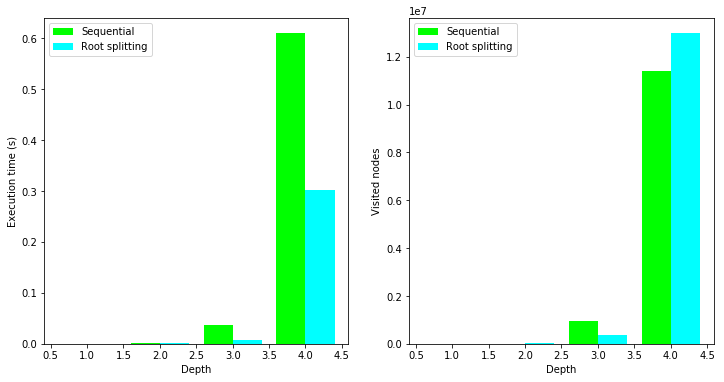

In [9]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 6) 

plotting(stats, "Sequential", "Root splitting")


The parallel seems to be clearly faster at depths 3 and 4, even if the number of visited nodes is slightly higher for the parallel engine.

In [11]:
stats.oldGlobalMean[-1]/stats.newGlobalMean[-1]

2.0030670691601475

We can see that the speedup at depth 4 is 2. Even though 4 threads are used, going two times faster is a good result.
Can we do better?

## Move reordering

   In the previous section we saw that adding parallelization considerably increased the performance of the engine in terms of execution time, but why stop when things are going so well? We can improve our model further by adding what we call move reordering.

We know that the minimax algorithm enumerates all the possible moves from a given node. At each step, the minimax evaluates the current node and assesses it as being promising or average. It is the job of the alpha beta technique to cut off the worst nodes, preventing the minimax from visiting them, thus gaining significant amounts of time.

The sooner we prune the better, as cutting off a node eliminates its entire descendance from the search tree. 
Reordering the children of a given node in a way to start exploring the most promising branches (a priori) generates more cut-offs. To reorder child nodes before exploring them, we must rely on the estimation function to evaluate those nodes. Improving the estimation function will of course give much better results, but that is the work of chess experts and is out of the scope of this notebook. The estimation we are working with is good enough, and is unchanged for all versions of the engine in this simulation.

The C code to add this feature is as simple as calling the evaluation function for all children nodes before exploring them, and sorting those nodes using the qsort builtin C function.

Let's test it: we'll run the simulation with our second C program as a parameter. It makes two parallel engine play against each other, one of them using the move reordering feature.


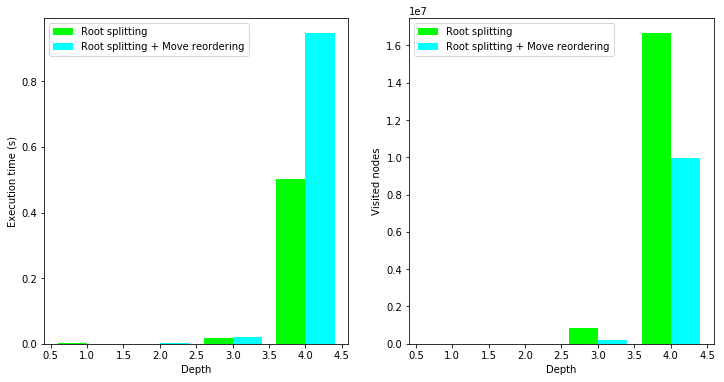

In [12]:
stats = simulation("./parallel_vs_parallel_with_reordering", nGames=1)

plotting(stats, "Root splitting", "Root splitting + Move reordering")

Reordering the moves seems to give out worse results! But why on earth would that happen? In fact, this behavior makes sense. 

Reordering the moves means computing the estimation function for every child of the visited node, and then sorting them. While we do get more cut-offs as expected (a lot less nodes visited than before), we lose time in the overhead of sorting and computing the estimation at every single node visited. 
This leads us to our next attempt..!


## Beam search

The beam search technique uses the move reordering to only explore the most promising nodes of the search tree; that is, after we reorder the children of a given node, we only explore a subset of those child nodes, by ignoring the least promising ones (according to the estimation function!), and thus making the search faster.
Of course the trade-off of doing so is to risk not exploring parts of the search tree that might lead to better moves.
More on Beam Search: 
https://en.wikipedia.org/wiki/Beam_search

To implement this feature, we only need to make the slight change of iterating through n/2 child nodes instead of n in the minimax function. We chose to only consider the most promising half of the children nodes.

Simulation...

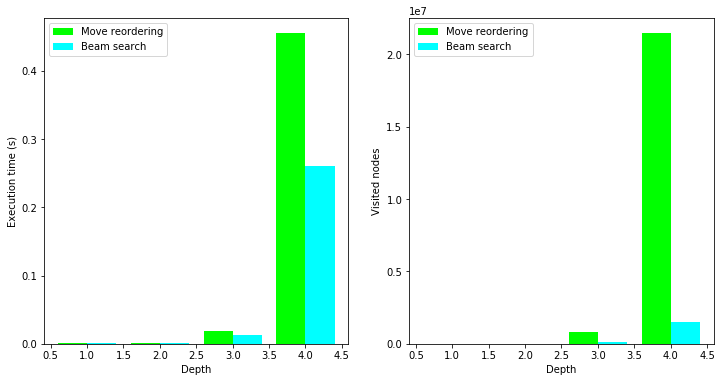

In [13]:
stats = simulation("./move_reorder_vs_beam_search", nGames=1)
plotting(stats, "Move reordering", "Beam search")

As expected, the execution time is reduced due to exploring less nodes, at the risk of losing some good moves due to a bad estimation. So for this technique to give good results, the estimation function must be goood (notice the extra ‘o’).
There is a huge difference in the number of visited nodes! It makes sense because we only considered half the child nodes at each minimax call, we probably would want to consider a little more than half of them if we were at a chess engine competition though.

Let's now test it against the initial sequential engine:

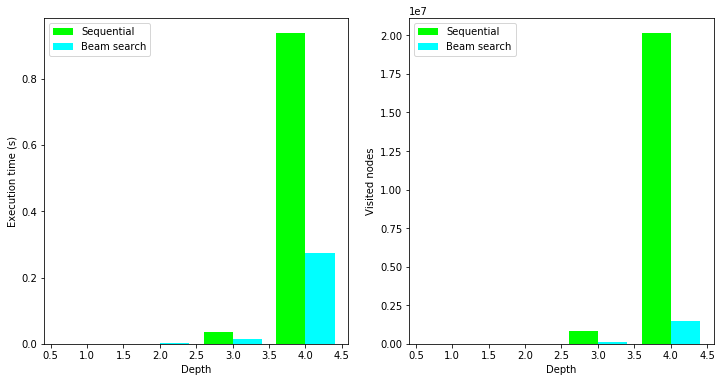

In [14]:
stats = simulation("./sequential_vs_beam_search", nGames=1)
plotting(stats, "Sequential", "Beam search")

In [15]:
stats.oldGlobalMean[-1]/stats.newGlobalMean[-1]

3.407518938821006

The speedup this time is 3.4!! That is impressive, but also expected. We're exploring a lot less nodes, first because we generate more cut-offs thanks to the reordering, and second because we consider less possibilities using beam search. The latter is risky, but gives good results when the estimation function has a low probability of giving inaccurate evaluations.

## Iterative deepening

Coming soon